In [ ]:
### ** imports + device**
import os, platform, json, torch, faiss, numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available(): # for macOS metal gpu
    device = "mps"
else:
    device = "cpu"
print(f"✓ running on ⇒ {device}")


ModuleNotFoundError: No module named 'typing_extensions'

In [2]:
if device == "cuda":
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:                                  # Ampere (8.x) or Ada (9.x)
        torch.backends.cuda.matmul.allow_tf32 = True
        print("✓ TF32 enabled")

    # ---- extra diagnostic lines (safe on all 2.x versions) ----
    print(f"CUDA toolkit  : {torch.version.cuda}")          # e.g. '12.1'
    try:
        drv = torch._C._cuda_getDriverVersion()             # int, e.g. 12030 → 12.3
        print(f"GPU driver   : {drv//1000}.{(drv//10)%100}") # '12.3'
    except AttributeError:
        print("GPU driver   : <unavailable>")
    print(f"GPU name      : {torch.cuda.get_device_name()}")


CUDA toolkit  : 12.6
GPU driver   : <unavailable>
GPU name      : Tesla V100-PCIE-16GB


In [3]:
# load CLIP backbone with open-clip

import open_clip, torch, re
model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-B-16",
        pretrained="laion400m_e32",
        device=device)
backbone = model.visual      
backbone.eval()                  # encoder

/home/disi/miniconda3/envs/clip-probe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
# right after backbone = model.visual
feature_dim = backbone.output_dim        # 512 for B/16

In [5]:
import torch
linear_names = [n for n, m in backbone.named_modules() if isinstance(m, torch.nn.Linear)]
print("Found", len(linear_names), "Linear layers:")
for n in linear_names[:40]:   # show first 40
    print("  ", n)


Found 36 Linear layers:
   transformer.resblocks.0.attn.out_proj
   transformer.resblocks.0.mlp.c_fc
   transformer.resblocks.0.mlp.c_proj
   transformer.resblocks.1.attn.out_proj
   transformer.resblocks.1.mlp.c_fc
   transformer.resblocks.1.mlp.c_proj
   transformer.resblocks.2.attn.out_proj
   transformer.resblocks.2.mlp.c_fc
   transformer.resblocks.2.mlp.c_proj
   transformer.resblocks.3.attn.out_proj
   transformer.resblocks.3.mlp.c_fc
   transformer.resblocks.3.mlp.c_proj
   transformer.resblocks.4.attn.out_proj
   transformer.resblocks.4.mlp.c_fc
   transformer.resblocks.4.mlp.c_proj
   transformer.resblocks.5.attn.out_proj
   transformer.resblocks.5.mlp.c_fc
   transformer.resblocks.5.mlp.c_proj
   transformer.resblocks.6.attn.out_proj
   transformer.resblocks.6.mlp.c_fc
   transformer.resblocks.6.mlp.c_proj
   transformer.resblocks.7.attn.out_proj
   transformer.resblocks.7.mlp.c_fc
   transformer.resblocks.7.mlp.c_proj
   transformer.resblocks.8.attn.out_proj
   transformer.

In [ ]:
# the purpose of PEFT is to allow training a small number of parameters
# PEFT might pass input_ids, so we need to wrap the backbone
# to allow passing pixel_values

from torch import nn

class ViTForPeft(nn.Module): #since the class derives from nn.Module, it will work as a neural network module in Pytorch 
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone #pre-trained CLIP backbone
    def forward(self, pixel_values=None, input_ids=None, **kwargs):
        #will make sure backbone always receives image data through pixel_values
        #images will be passed as pixel_values in the (B×3×H×W) format
        if pixel_values is None:
            pixel_values = input_ids          # backup plan if pixel_values is not provided
        return self.backbone(pixel_values)    # standard OpenCLIP call

backbone_peft = ViTForPeft(backbone)          # now we can use the backbone with PEFT

In [ ]:
#this function will return a list of valid LoRA targets - i.e., layesrs that can be adapted with LoRA.
#LoRA is a technique that allows training a small number of parameters while keeping the rest of the model frozen.
def get_valid_lora_targets(model):
    valid_types = (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Conv3d, torch.nn.MultiheadAttention)
    targets = []
    for name, module in model.named_modules():
        if isinstance(module, valid_types):
            targets.append(name)
    return targets

valid_targets = get_valid_lora_targets(backbone)
print(valid_targets) #paramenters that can be adapted with LoRA


['conv1', 'transformer.resblocks.0.attn', 'transformer.resblocks.0.attn.out_proj', 'transformer.resblocks.0.mlp.c_fc', 'transformer.resblocks.0.mlp.c_proj', 'transformer.resblocks.1.attn', 'transformer.resblocks.1.attn.out_proj', 'transformer.resblocks.1.mlp.c_fc', 'transformer.resblocks.1.mlp.c_proj', 'transformer.resblocks.2.attn', 'transformer.resblocks.2.attn.out_proj', 'transformer.resblocks.2.mlp.c_fc', 'transformer.resblocks.2.mlp.c_proj', 'transformer.resblocks.3.attn', 'transformer.resblocks.3.attn.out_proj', 'transformer.resblocks.3.mlp.c_fc', 'transformer.resblocks.3.mlp.c_proj', 'transformer.resblocks.4.attn', 'transformer.resblocks.4.attn.out_proj', 'transformer.resblocks.4.mlp.c_fc', 'transformer.resblocks.4.mlp.c_proj', 'transformer.resblocks.5.attn', 'transformer.resblocks.5.attn.out_proj', 'transformer.resblocks.5.mlp.c_fc', 'transformer.resblocks.5.mlp.c_proj', 'transformer.resblocks.6.attn', 'transformer.resblocks.6.attn.out_proj', 'transformer.resblocks.6.mlp.c_fc',

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType



final_targets = [] 
lorizzabili = valid_targets  # the list of valid LoRA targets we previously obtained 
#we will use this list to determine the final targets for LoRA adaptation

# 1. Using the Original Model (without PEFT) to Determine Targets
print("🔍 Determinazione target usando il modello originale...")
for block_idx, block in enumerate(backbone.transformer.resblocks[-4:]): #we want to focus on the last four blocks of the transformer
    for name, module in block.named_modules(): 
        if isinstance(module, torch.nn.Linear): 
            full_name = f"transformer.resblocks.{len(backbone.transformer.resblocks)-4+block_idx}.{name}" 
            if full_name in lorizzabili: #double check if the full name is in the list of valid LoRA targets
                final_targets.append(full_name) 

final_targets = list(set(final_targets)) #removes duplicates
print(f"🎯 Target LoRA finali: {final_targets}") #all the final parameters to which we will apply LoRA

# 2. Creating the LoRA Configuration
peft_cfg_fixed = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION, #main job of our model is feature extraction
    r=16, #rank of the LoRA layers, determines the number of parameters to be added to the model, 16 is a small value that allows for efficient adaptation
    lora_alpha=16, #scaling factor for the LoRA layers, generally set to the same value as r
    lora_dropout=0.05, #turns on dropout for the LoRA layers, helps prevent overfitting
    target_modules=final_targets, #list of target modules to which LoRA will be applied
)

# 3. create wrapper PEFT with the right configuration
print("🔧 Creazione wrapper PEFT con target corretti...")
backbone_peft = get_peft_model(backbone, peft_cfg_fixed)

# 4. double check that LoRA is applied correctly within the wrapper 
print("\n✅ Verifica moduli LoRA applicati:")
lora_modules = []
for name, module in backbone_peft.named_modules():
    if hasattr(module, 'lora_A') or 'lora' in str(type(module)).lower(): #iif a module has a lora_A or lora attribute, it means LoRA was applied to it
        lora_modules.append(name)

print(f"\n📊 Totale moduli LoRA applicati: {len(lora_modules)}")
print(f"📊 Target richiesti: {len(final_targets)}")



ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/disi/miniconda3/envs/clip-probe/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda126.so)
Traceback (most recent call last):
  File "/home/disi/miniconda3/envs/clip-probe/lib/python3.10/site-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
  File "/home/disi/miniconda3/envs/clip-probe/lib/python3.10/site-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
  File "/home/disi/miniconda3/envs/clip-probe/lib/python3.10/ctypes/__init__.py", line 452, in LoadLibrary
    return self._dlltype(name)
  File "/home/disi/miniconda3/envs/clip-probe/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (requir

🔍 Determinazione target usando il modello originale...
🎯 Target LoRA finali: ['transformer.resblocks.9.attn.out_proj', 'transformer.resblocks.10.attn.out_proj', 'transformer.resblocks.11.mlp.c_proj', 'transformer.resblocks.10.mlp.c_fc', 'transformer.resblocks.8.attn.out_proj', 'transformer.resblocks.11.attn.out_proj', 'transformer.resblocks.10.mlp.c_proj', 'transformer.resblocks.8.mlp.c_proj', 'transformer.resblocks.11.mlp.c_fc', 'transformer.resblocks.9.mlp.c_fc', 'transformer.resblocks.9.mlp.c_proj', 'transformer.resblocks.8.mlp.c_fc']
🔧 Creazione wrapper PEFT con target corretti...

✅ Verifica moduli LoRA applicati:

📊 Totale moduli LoRA applicati: 13
📊 Target richiesti: 12

🔍 Verifica target applicati:
  ✅ transformer.resblocks.9.attn.out_proj: LoRA applicato
  ✅ transformer.resblocks.10.attn.out_proj: LoRA applicato
  ✅ transformer.resblocks.11.mlp.c_proj: LoRA applicato
  ✅ transformer.resblocks.10.mlp.c_fc: LoRA applicato
  ✅ transformer.resblocks.8.attn.out_proj: LoRA applicato

In [ ]:
# Apply LoRA to the last 4 blocks (blocks[-4:])

from peft import LoraConfig, get_peft_model, TaskType
import torch

from torch.utils.checkpoint import checkpoint
from functools import partial


# enables gradient checkpointing for memory efficiency
target_blocks = [8, 9, 10, 11]
for i in target_blocks:
    model.visual.transformer.resblocks[i].gradient_checkpointing = True
model.visual.transformer.gradient_checkpointing = True

# Freeze all parameters except the last 4 blocks
vit_blocks = list(backbone_peft.transformer.resblocks)
for blk in vit_blocks[:-4]:
    for name, param in blk.named_parameters():
        if 'lora_' not in name:
            param.requires_grad = False
#checks trainable parameters
backbone_peft.print_trainable_parameters()


trainable params: 589,824 || all params: 86,782,464 || trainable%: 0.6797

--- FREEZING NON-TARGET LoRA ADAPTERS ---
trainable params: 589,824 || all params: 86,782,464 || trainable%: 0.6797


In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# robustly get feature dimension of a backbone
def get_feature_dim(b):
    if hasattr(b, "embed_dim"):#if the backbone has an embed_dim attribute
        return b.embed_dim
    if hasattr(b, "output_dim"): #if the backbone has an output_dim attribute
        return b.output_dim
    return b.proj.shape[1]        # last resort, if the backbone has a proj attribute, return its second dimension


class CLIPProbe(nn.Module): #part of our neural network
    def __init__(self, backbone_peft, prototype_dim=512): # size of the output feature vector (it depends on the model)
        self.backbone_peft = backbone_peft #    LoRA tuned backbone with PEFT will be stored here
        vision_feature_dim = 512 # Per CLIP ViT-B/16, hidden_size è 768
        self.projector = nn.Sequential( #we build a projector to map the features to the prototype dimension
            nn.Linear(vision_feature_dim, 512), 
            nn.ReLU(),         #makes network non-linear, thus able to learn more complext functions                  
            nn.Dropout(0.1),                    # Dropout to prevent overfitting
            nn.Linear(512, prototype_dim)       
        )        
    def forward(self, x):
        x = self.backbone_peft(pixel_values=x) #x, aka the image, is passed through the backbone with LoRA
        return nn.functional.normalize(self.projector(x), dim=-1) #then the image is passed through the projector and normalized along the last dimesnion of the output vector (for better comparability of the features)


In [ ]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from pathlib import Path
import os
import torch
from PIL import ImageFile

#quick set up of our training and validation datasets
# loads images even if they are truncated or corrupted
ImageFile.LOAD_TRUNCATED_IMAGES = True

#identify directories
train_dir   = Path("train")
query_dir   = Path("test/query")
gallery_dir = Path("test/gallery")


full_set = ImageFolder(train_dir, transform=preprocess) # training images are preprocessed aka cropped, resized, normalized and converted to a tensor
#extracts all labels from the dataset
labels_all = full_set.targets  

print(f"Dataset size: {len(full_set)} images")
print(f"Number of classes: {len(set(labels_all))}")

#dataset splitting
# get all indices
idx_all = list(range(len(full_set)))

# splits the indices
train_idx, val_idx = train_test_split(
    idx_all, 
    test_size=0.20,
    stratify=labels_all, 
    random_state=42
)

train_set = Subset(full_set, train_idx)
val_set = Subset(full_set, val_idx)

print(f"Train set: {len(train_set)} images")
print(f"Val set: {len(val_set)} images")

# sets to use CPU workers to load and preprocess images while GPU is training
num_workers = min(os.cpu_count(), 8)  # Cap at 8 to avoid diminishing returns
print(f"⚙️ Using {num_workers} workers")

# Optimize batch size based on available memory
def get_optimal_batch_size():
    """Determine optimal batch size based on available GPU memory"""
    if torch.cuda.is_available():
        # Get GPU memory
        gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        if gpu_memory_gb >= 16:
            return 256  # High-end GPU
        elif gpu_memory_gb >= 8:
            return 128  # Mid-range GPU
        else:
            return 64   # Lower-end GPU
    else:
        return 32  # CPU fallback

optimal_batch_size = get_optimal_batch_size()
print(f"🎯 Using batch size: {optimal_batch_size}")

#set up dataloaders
train_loader = DataLoader(
    train_set, 
    batch_size=optimal_batch_size,
    shuffle=True, #images are shuffled for better training
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),  # Pin memory for faster GPU transfer
    persistent_workers=True,               # Keep workers alive between epochs
    prefetch_factor=2,                     # worker must load and preprocess 2 batches in advance
    drop_last=True                         # Drop incomplete batch for consistent training (trains on full batches only, if some images are left they are discarded)
)

#same as above
val_loader = DataLoader(
    val_set,
    batch_size=optimal_batch_size,
    shuffle=False, #images are not shuffled for validation
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=True # <-- AGGIUNGI QUESTA RIGA
)

print("DataLoaders created successfully!")


📁 Loading dataset...
🏷️ Extracting labels (optimized)...
📊 Dataset size: 30607 images
📊 Number of classes: 257
✂️ Splitting dataset...
📚 Train set: 24485 images
🔍 Val set: 6122 images
⚙️ Using 6 workers
🎯 Using batch size: 128
🚀 Creating optimized DataLoaders...
✅ DataLoaders created successfully!
🔥 Pre-warming DataLoaders...
⏱️ First batch load time: 1518.0ms
📦 Batch shape: torch.Size([128, 3, 224, 224])
🏷️ Labels shape: torch.Size([128])
🧠 GPU Memory: 0.56GB / 15.77GB used

🎯 PERFORMANCE OPTIMIZATIONS APPLIED:
✅ Direct label access (no image loading)
✅ Optimal batch size selection
✅ Pin memory for GPU transfer
✅ Persistent workers
✅ Prefetch factor optimization
✅ Pre-warming completed

📊 Train Loader Performance Test:
  ⏱️ Average batch time: 660.5ms
  🚀 Throughput: ~194 images/sec

📊 Val Loader Performance Test:
  ⏱️ Average batch time: 744.9ms
  🚀 Throughput: ~172 images/sec

🎉 Optimized data loading setup complete!
📈 Expected speedup: 2-4x faster than original code


In [ ]:
# model, loss, optimiser
dim      = feature_dim                  # use the cached value
model_ft = CLIPProbe(backbone_peft, dim).to(device)

# counts number of classes in the dataset
num_classes = len(full_set.classes)          
cls_prot    = nn.Parameter(torch.empty(num_classes, dim, device=device)) #defines a learnable parameter for the class prototypes
nn.init.xavier_uniform_(cls_prot)

criterion  = nn.CrossEntropyLoss() #we use CrossEntropyLoss

#checks trainable parameters (I had some issues with this, this is some additional debugging to be on the safe side)
for n, p in model_ft.backbone_peft.named_parameters():
    if "lora_" in n:
        p.requires_grad_(True)
        print(f"LoRA unfrozen for training: {n}") #to check
    else: # Importante: Assicurati che gli altri parametri del backbone siano ancora congelati
        p.requires_grad_(False)
#trainable LoRA parameters
lora_params_final = [p for n, p in model_ft.named_parameters() if 'lora_' in n and p.requires_grad] # Sarà vuoto
#trainable projector parameters
projector_params_final = [p for p in model_ft.projector.parameters() if p.requires_grad]

print(f"DEBUG: Parametri LoRA allenabili: {len(lora_params_final)}") 
print(f"DEBUG: Parametri Projector allenabili: {len(projector_params_final)}")

#sets up diffirent learning rates for LoRA and projector
# LoRA parameters are trained with a lower learning rate than the projector
optim = torch.optim.AdamW([
    {'params': lora_params_final, 'lr': 1e-4}, 
    {'params': projector_params_final, 'lr': 5e-4}
])

LoRA unfrozen for training: base_model.model.transformer.resblocks.8.attn.out_proj.lora_A.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.8.attn.out_proj.lora_B.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.8.mlp.c_fc.lora_A.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.8.mlp.c_fc.lora_B.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.8.mlp.c_proj.lora_A.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.8.mlp.c_proj.lora_B.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.9.attn.out_proj.lora_A.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.9.attn.out_proj.lora_B.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.9.mlp.c_fc.lora_A.default.weight
LoRA unfrozen for training: base_model.model.transformer.resblocks.9.mlp.c_f

In [15]:
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import get_scheduler # Per lo scheduler di learning rate

In [ ]:
#we initialize a scheduler for the optimizer, which will adjust the learning rate during training
#the lr will be adjusted from the intial value to almost zero during training
num_epochs_total = 5 # must correspond to the number of epochs for the training loop
num_training_steps_total = len(train_loader) * num_epochs_total

warmup_steps = int(0.1 * num_training_steps_total) 

scheduler = get_scheduler(
    name="linear", # o "cosine"
    optimizer=optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps_total,
)



Scheduler Stage 2 initialized: Warmup steps: 95, Total steps: 955


In [ ]:
# MAIN TRAINING LOOP
num_epochs = num_epochs_total   # big upper bound – early-stop will cut it short

patience    = 3 #epochs without improvement before early stopping
delta       = 1e-4    # min improvement to reset patience

train_loss_hist, val_loss_hist = [], []
val_acc_hist    = []

best_val = float('inf')
epochs_no_imp = 0

# adaptive accumulation steps
accumulation_steps = 1
max_accumulation_steps = 8
threshold_increase = 0.05

for epoch in range(1, num_epochs + 1):

    # ----- TRAIN -----
    model_ft.train() #model wiyh LoRA is set to training mode
    running_loss = 0.0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device) #images and labels from CPU to GPU
        vision_output = model_ft.backbone_peft.base_model.model(imgs) #images fed to the backbone
        feats = vision_output.detach().clone().requires_grad_(True) #features are extracted from the backbone, detached from the graph and set to require gradients
        feats = model_ft.projector(feats) #features are extracted and passed through the projector that transforms them to the prototype dimension
        feats = torch.nn.functional.normalize(feats, dim=-1) #features are normalized along the last dimension for better comparability
        logits = feats @ cls_prot.T #matrix multiplication between the features and the class prototypes to get the logits (raw predictions)
        loss   = criterion(logits, labels) #calculates loss for the current batch using logits and labels
        loss = loss / accumulation_steps # divide loss by accumulation steps to average it over multiple batches
        loss.backward() #backpropagation to compute gradients
        if (i + 1) % accumulation_steps == 0: #if we reached the accumulation steps
            optim.step() #update the model parameters
            optim.zero_grad() #reset gradients to zero
            scheduler.step() # update the learning rate according to the scheduler (now it's linear)
        running_loss += loss.item() * accumulation_steps
    avg_train = running_loss / len(train_loader)
    train_loss_hist.append(avg_train)

    #basically same as above, but with validation data
    # ----- VALIDATE -----
    model_ft.eval()
    v_loss, v_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            vision_output = model_ft.backbone_peft.base_model.model(imgs)
            feats = vision_output.detach().clone().requires_grad_(True) 
            feats = model_ft.projector(feats)
            feats = torch.nn.functional.normalize(feats, dim=-1)

            logits = feats @ cls_prot.T
            v_loss += criterion(logits, labels).item()
            v_correct += (logits.argmax(1) == labels).sum().item()

    avg_val = v_loss / len(val_loader)
    val_loss_hist.append(avg_val)
    val_acc  = v_correct / len(val_set)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:02d} │ "
              f"train loss {avg_train:.4f} │ "
              f"val loss {avg_val:.4f} │ "
              f"val acc {val_acc:.3%}")
    # ----- EARLY-STOP -----
    if avg_val < best_val - delta:
        best_val = avg_val
        epochs_no_imp = 0
        torch.save(
            {"model_ft": model_ft.state_dict(),
             "cls_prot": cls_prot.detach().cpu()},
            "best_probe.pt")
        print("💾 Saved best model checkpoint")
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print(f"🛑 Early stop at epoch {epoch} – no val-improvement for {patience} rounds.")
            break

Epoch 01 │ train loss 5.2220 │ val loss 4.9264 │ val acc 81.460%
💾 Saved best model checkpoint
Epoch 02 │ train loss 4.8599 │ val loss 4.7723 │ val acc 87.929%
💾 Saved best model checkpoint
Epoch 03 │ train loss 4.7495 │ val loss 4.7057 │ val acc 89.840%
💾 Saved best model checkpoint
Epoch 04 │ train loss 4.6957 │ val loss 4.6748 │ val acc 90.918%
💾 Saved best model checkpoint
Epoch 05 │ train loss 4.6695 │ val loss 4.6655 │ val acc 91.228%
💾 Saved best model checkpoint
Epoch 06 │ train loss 4.6615 │ val loss 4.6655 │ val acc 91.228%
Epoch 07 │ train loss 4.6622 │ val loss 4.6655 │ val acc 91.228%
Epoch 08 │ train loss 4.6623 │ val loss 4.6655 │ val acc 91.228%
🛑 Early stop at epoch 8 – no val-improvement for 3 rounds.


NameError: name 'initial_lora_params' is not defined

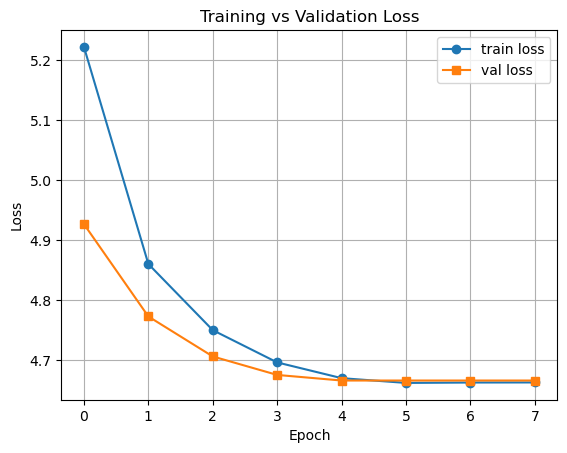

✔ Best epoch (lowest val loss): 5


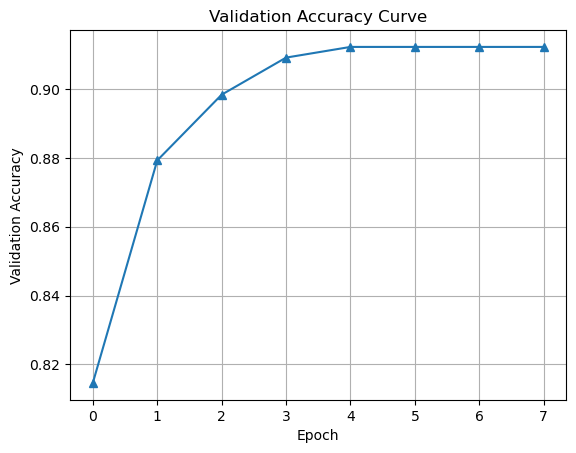

In [ ]:
import matplotlib.pyplot as plt
# PLOT train & val curves    
plt.figure()
plt.plot(train_loss_hist, label="train loss", marker='o')
plt.plot(val_loss_hist,   label="val loss",   marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

best_epoch = 1 + val_loss_hist.index(min(val_loss_hist))
print(f"✔ Best epoch (lowest val loss): {best_epoch}")

plt.figure()
plt.plot(val_acc_hist, marker='^')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Curve")
plt.grid(True)
plt.show()


In [ ]:
#LOAD best weights before inference

# in this way we use the weights of the best epoch number for inference

ckpt = torch.load("best_probe.pt", map_location=device)
model_ft.load_state_dict(ckpt["model_ft"])
cls_prot.data.copy_(ckpt["cls_prot"].to(device))
model_ft.eval()


CLIPProbe(
  (backbone_peft): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (patch_dropout): Identity()
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): ModuleList(
            (0-7): 8 x ResidualAttentionBlock(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ls_1): Identity()
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): GELU(approximate='none')
                (c_proj): Linear(in_features=3072, out_fea

In [ ]:
import torch
from PIL import Image
from pathlib import Path
import numpy as np
from tqdm import tqdm # For progress bars

# Ensure 'model', 'preprocess', and 'device' are available from your previous cells.

def embed(image_path: Path, model, preprocess_fn, device: str):
    image = Image.open(image_path).convert("RGB")
    # Preprocess the image and add a batch dimension
    image_input = preprocess_fn(image).unsqueeze(0).to(device)
    with torch.no_grad():
        # This will internally call model.visual.forward(image_input)
        # which is now your PEFT-wrapped ViTForPeft instance.
        image_features = model.encode_image(image_input)

    # Normalize features and convert to NumPy array
    # (Normalization is standard practice for CLIP embeddings)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.cpu().numpy().flatten()


def embed_folder(folder_path: Path, model, preprocess_fn, device: str, pattern: str = "*.jpg"):
    """
    Generates embeddings for all images in a specified folder.

    Args:
        folder_path (Path): Path to the folder containing images.
        model: The CLIP model (with the PEFT-wrapped visual backbone).
        preprocess_fn: The image preprocessing function (from open_clip).
        device (str): The device to run inference on ('cuda', 'cpu', 'mps').
        pattern (str): Glob pattern to match image files (e.g., "*.jpg", "*.png").

    Returns:
        tuple[np.ndarray, list[str]]: A tuple containing:
            - np.ndarray: A 2D array of embeddings (num_images, embedding_dim).
            - list[str]: A list of corresponding image filenames.
    """
    vecs, names = [], []
    # Use tqdm for a progress bar as embedding a folder can take time
    for p in tqdm(sorted(folder_path.glob(pattern)), desc=f"Embedding {folder_path.name}"):
        vecs.append(embed(p, model, preprocess_fn, device))
        names.append(p.name)
    return np.vstack(vecs), names

In [ ]:
# Assuming query_dir and gallery_dir are already defined as Path objects)

print("Generating gallery embeddings...")
gallery_vecs, gallery_files = embed_folder(gallery_dir, model, preprocess, device)
print(f"Generated {len(gallery_vecs)} gallery embeddings. Shape: {gallery_vecs.shape}")

print("\nGenerating query embeddings...")
query_vecs, query_files = embed_folder(query_dir, model, preprocess, device)
print(f"Generated {len(query_vecs)} query embeddings. Shape: {query_vecs.shape}")

Generating gallery embeddings...


Embedding gallery_images: 100%|██████████| 4380/4380 [01:15<00:00, 58.11it/s]


Generated 4380 gallery embeddings. Shape: (4380, 512)

Generating query embeddings...


Embedding query_images: 100%|██████████| 1477/1477 [00:25<00:00, 57.08it/s]

Generated 1477 query embeddings. Shape: (1477, 512)


In [ ]:
#faiss performs L2 normalization on the vectors to ensure they are unit vectors
faiss.normalize_L2(gallery_vecs)
faiss.normalize_L2(query_vecs)

index = faiss.IndexFlatIP(gallery_vecs.shape[1]) #finds vectors with the highest inner product (IP) similarity (cosine similarity)
index.add(gallery_vecs)

k = 10   #returns the 10 most simmilar images
_, neigh = index.search(query_vecs, k)


In [26]:

# ----- JSON submission writer -----
entries = []
for qi, row in enumerate(neigh):
    hits = [gallery_files[j] for j in row]          # exactly k hits
    entries.append({"filename": query_files[qi],
                    "samples":  hits})

with open("submission.json", "w") as f:
    json.dump(entries, f, indent=2)

print("✅ submission.json saved  |  queries:", len(entries))


✅ submission.json saved  |  queries: 1477


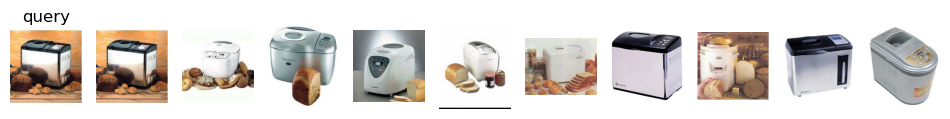

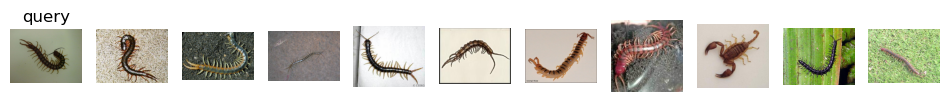

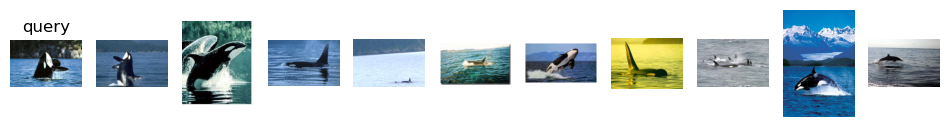

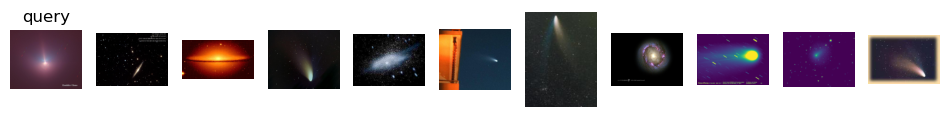

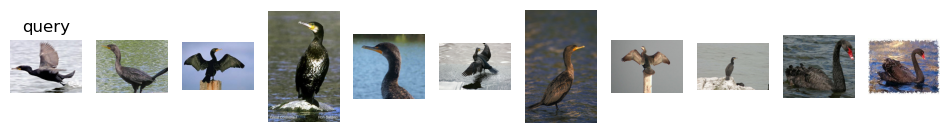

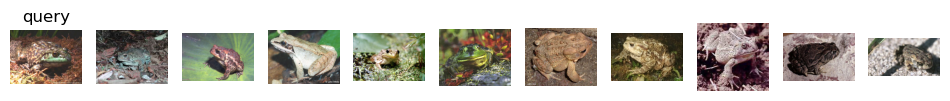

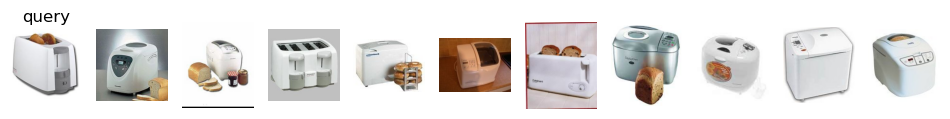

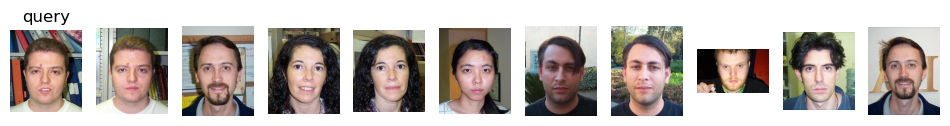

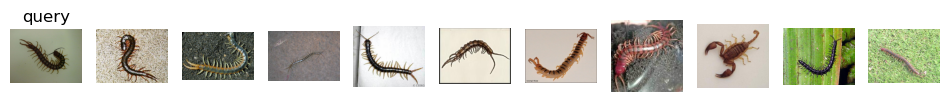

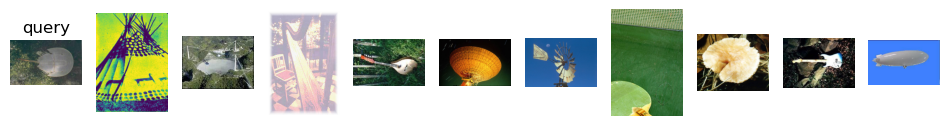

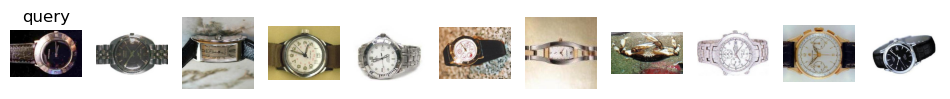

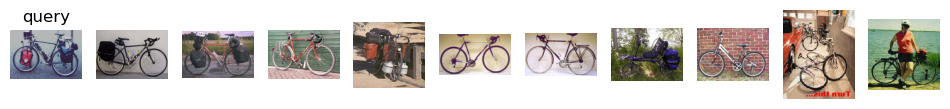

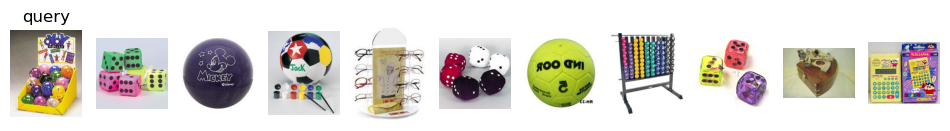

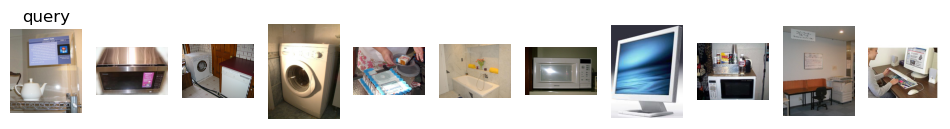

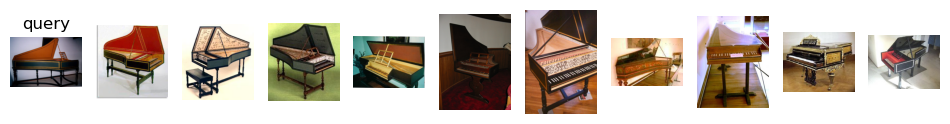

In [27]:
# quick visual sanity-check

import matplotlib.pyplot as plt
import random


def show_query(idx):
    plt.figure(figsize=(12, 2))
    # show query
    q_img = Image.open(query_dir / query_files[idx])
    plt.subplot(1, k+1, 1); plt.imshow(q_img); plt.axis("off"); plt.title("query")
    # show retrieved gallery images
    for i, j in enumerate(neigh[idx], start=2):
        g_img = Image.open(gallery_dir / gallery_files[j])
        plt.subplot(1, k+1, i); plt.imshow(g_img); plt.axis("off")
    plt.show()

for _ in range(15):
    show_query(random.randrange(len(query_files)))
